<a href="https://colab.research.google.com/github/rathoreashish146/Flood-Stage-Prediction-System/blob/main/GRU_and_Bi_LSTM_wtih_attention_on_sweetwater.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import pandas as pd
import numpy as np
import seaborn as sns
import pandas_datareader as pdr
from datetime import datetime
from pandas import DataFrame
from pandas import concat
import matplotlib.pyplot as plt
import tensorflow as tf

In [ ]:
!sudo pip3 install keras

from tensorflow.python.keras.engine.sequential import Sequential

from tensorflow.python.keras.layers import Dense, Conv2D, Flatten, Dropout, MaxPooling2D

from tensorflow.keras.layers import Dense, Activation, Dropout
from tensorflow.keras.layers import LSTM ,Conv1D, MaxPooling1D, Flatten
from tensorflow.keras.models import Sequential
from sklearn.metrics import mean_squared_error
from sklearn import metrics
from keras.layers import Dense, LSTM, Dropout, GRU, Bidirectional
from matplotlib import pyplot
%matplotlib inline

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
#first we take columbus data set
# data = pd.read_csv('/content/chattahoochee-columbus.csv')

#first we take sweetwater creek data set
data = pd.read_csv('/content/SWEETWATER CREEK.csv')

In [ ]:
# data.head()

In [ ]:
# data.shape

In [ ]:
print("Start: ", data['time'].min())
print("End: ", data['time'].max())

Start:  1/1/2015 0:00
End:  9/9/2021 9:45


In [ ]:
data[['date', 'Only_time']] = data['time'].str.split(' ', 1, expand=True)

<ipython-input-7-8490a75142d0>:1: FutureWarning: In a future version of pandas all arguments of StringMethods.split except for the argument 'pat' will be keyword-only.
  data[['date', 'Only_time']] = data['time'].str.split(' ', 1, expand=True)


In [ ]:
# data.head()

In [ ]:
data = data.drop(labels=['time'],axis=1)

In [ ]:
# data.head()

In [ ]:
#
# data.info()

In [ ]:
# data.describe()

In [ ]:
# data.isnull().sum()

In [ ]:
data['date'] = pd.to_datetime(data['date'])

In [ ]:
data['Only_time'] = pd.to_datetime(data['Only_time'])

In [ ]:
# data.info()

In [ ]:
# data.head()

In [ ]:
# Not converting into seperate columns
df = pd.read_csv('/content/SWEETWATER CREEK.csv')

In [ ]:
df['time'] = pd.to_datetime(df['time'])

In [ ]:
# df.head()

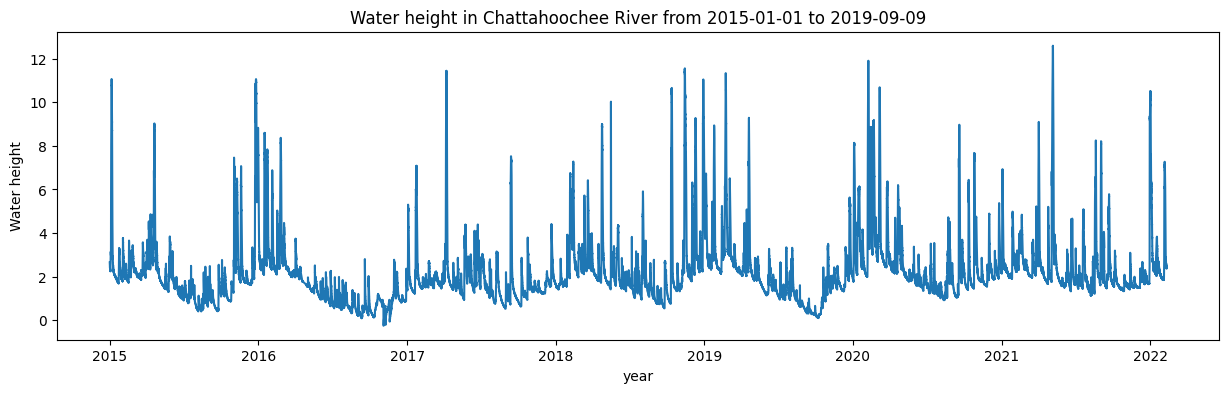

In [ ]:
plt.figure(figsize=(15,4))
plt.plot(df['time'],df['height'])
plt.gca().set(title='Water height in Chattahoochee River from 2015-01-01 to 2019-09-09', xlabel='year', ylabel='Water height')
plt.show()

<Axes: >

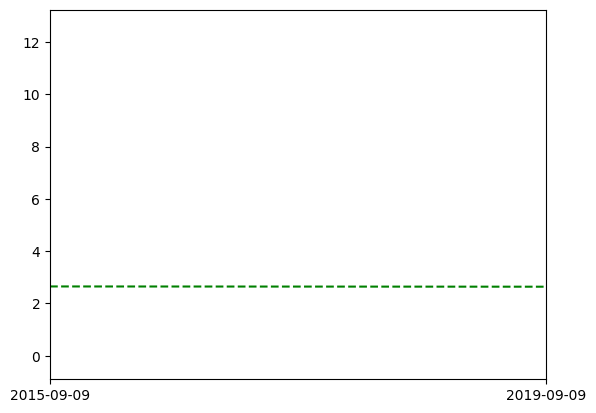

In [ ]:
df['height'].plot(xlim=['2015-09-09','2019-09-09'],ls='--',c='green')

In [ ]:
df.index

RangeIndex(start=0, stop=245630, step=1)

In [ ]:
# df.head()

In [ ]:
df = df.set_index('time',drop=True)

<Axes: xlabel='time'>

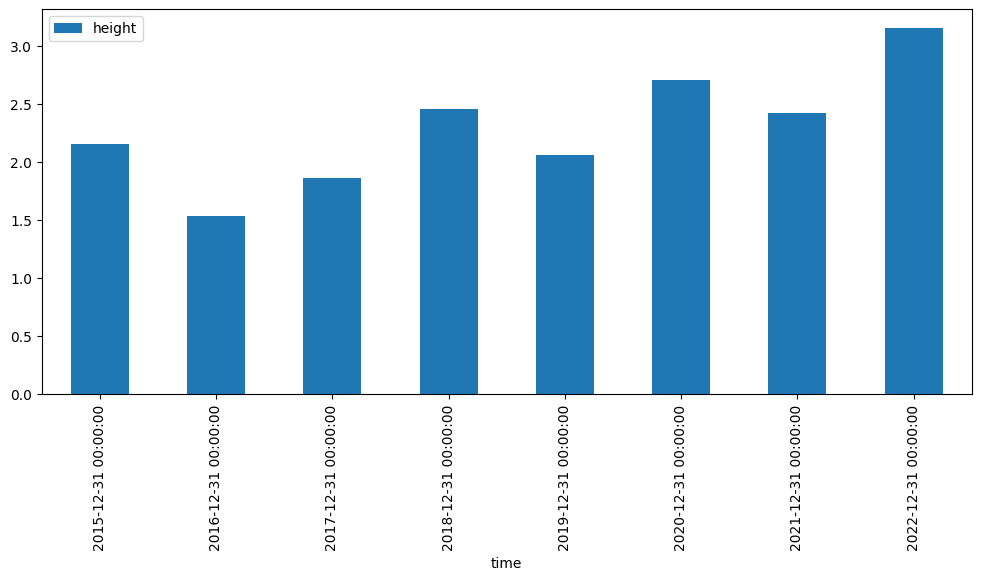

In [ ]:
df.resample(rule='A').mean().plot(kind='bar',figsize=(12,5))

In [ ]:
 #Extracting features from date and time this way creating  new features.
data['Month'] = [i.month for i in data['date']]
data['Year'] = [i.year for i in data['date']]
data['day'] = [i.day for i in data['date']]
data['Hour'] = [i.hour for i in data['Only_time']]
data['Minute'] = [i.minute for i in data['Only_time']]
data['Second'] = [i.second for i in data['Only_time']]
#drop unnecessary  columns and re-arrange
data.drop('Minute',axis=1, inplace=True)
data.drop('Second',axis=1, inplace=True)
data = data[['Year', 'Month', 'day', 'Hour', 'height']]
data

,Year,Month,day,Hour,height
0,2015,1,1,0,2.65
1,2015,1,1,0,2.64
2,2015,1,1,0,2.64
3,2015,1,1,0,2.62
4,2015,1,1,1,2.58
...,...,...,...,...,...
245625,2022,2,9,15,2.39
245626,2022,2,9,16,2.36
245627,2022,2,9,16,2.37
245628,2022,2,9,16,2.40


In [ ]:
#create a dataframe that contains water level/height values at 't'
temps = DataFrame(data['height'].values)
# shift forward and concatenate with data
temps_shift = concat([temps.shift(1, axis = 0),temps], axis=1)
data = concat([data, temps_shift], axis=1)
#drop repeated column
data.drop('height',axis=1, inplace=True)
#re-arrange
data.columns = ['Year', 'Month', 'day', 'Hour','t', 't+1']
#drop the first row with NaN value
data.dropna(axis=0, inplace=True)
data

,Year,Month,day,Hour,t,t+1
1,2015,1,1,0,2.65,2.64
2,2015,1,1,0,2.64,2.64
3,2015,1,1,0,2.64,2.62
4,2015,1,1,1,2.62,2.58
5,2015,1,1,1,2.58,2.62
...,...,...,...,...,...,...
245625,2022,2,9,15,2.41,2.39
245626,2022,2,9,16,2.39,2.36
245627,2022,2,9,16,2.36,2.37
245628,2022,2,9,16,2.37,2.40


In [ ]:
train = data[data['Year'] <= 2018]
valid = data[(data['Year'] > 2018) & (data['Year'] < 2020)]
test = data[data['Year'] >= 2020]

In [ ]:
#Separating the input and output variables
train_X = train.iloc[:,:-1]
train_y = train.iloc[:,-1]
valid_X = valid.iloc[:,:-1]
valid_y = valid.iloc[:,-1]
test_X = test.iloc[:,:-1]
test_y = test.iloc[:,-1]

In [ ]:
train_X = train_X.values
print('train_X shape:', train_X.shape)
train_y = train_y.values
print('train_y shape:', train_y.shape)
valid_X = valid_X.values
print('valid_X shape:', valid_X.shape)
valid_y = valid_y.values
print('valid_y shape:', valid_y.shape)
test_X = test_X.values
print('test_X shape:', test_X.shape)
test_y = test_y.values
print('test_y shape:', test_y.shape)

train_X shape: (137549, 5)
train_y shape: (137549,)
valid_X shape: (34789, 5)
valid_y shape: (34789,)
test_X shape: (73291, 5)
test_y shape: (73291,)


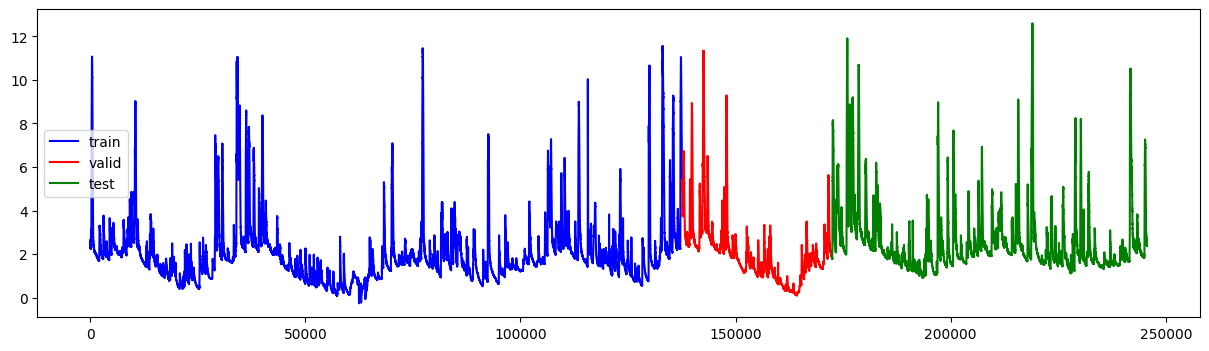

In [ ]:
#plot the distribution of train /valid/ test samples
x1=np.arange(0,137549)
x2 = np.arange(137549,172338)
x3 = np.arange(172338,245629)
plt.figure(figsize=(15,4), dpi=100)
plt.plot(x1,train_y,'b',label='train')
plt.plot(x2, valid_y, 'r', label='valid')
plt.plot(x3,test_y,'g',label='test')
plt.legend(loc='best')

In [ ]:
#reshape the train/valid/test datasets as it matche the CNN input
train_Xcnn = train_X.reshape((train_X.shape[0], train_X.shape[1], 1))
valid_Xcnn = valid_X.reshape((valid_X.shape[0], valid_X.shape[1], 1))
test_Xcnn = test_X.reshape((test_X.shape[0], test_X.shape[1], 1))
print('Train set shape', train_Xcnn.shape)
print('Validation set shape', valid_Xcnn.shape)
print('Validation set shape', test_Xcnn.shape)


Train set shape (137549, 5, 1)
Validation set shape (34789, 5, 1)
Validation set shape (73291, 5, 1)


In [ ]:
!pip install keras-tuner


Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 176.1/176.1 kB 4.2 MB/s eta 0:00:00


In [ ]:
!pip install tensorflow-addons==0.16.1
import tensorflow_addons as tfa

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 15.5 MB/s eta 0:00:00


/usr/local/lib/python3.10/dist-packages/tensorflow_addons/utils/ensure_tf_install.py:53: UserWarning: Tensorflow Addons supports using Python ops for all Tensorflow versions above or equal to 2.6.0 and strictly below 2.9.0 (nightly versions are not supported). 
 The versions of TensorFlow you are currently using is 2.12.0 and is not supported. 
Some things might work, some things might not.
If you were to encounter a bug, do not file an issue.
If you want to make sure you're using a tested and supported configuration, either change the TensorFlow version or the TensorFlow Addons's version. 
You can find the compatibility matrix in TensorFlow Addon's readme:
https://github.com/tensorflow/addons
  warnings.warn(


In [ ]:
import tensorflow as tf
from tensorflow.keras import layers

class AttentionLayer(layers.Layer):
    def __init__(self):
        super(AttentionLayer, self).__init__()

    def build(self, input_shape):
        self.W = self.add_weight(name='att_weights', shape=(input_shape[-1], 1), initializer='random_normal', trainable=True)
        self.b = self.add_weight(name='att_bias', shape=(input_shape[1], 1), initializer='zeros', trainable=True)
        super(AttentionLayer, self).build(input_shape)

    def call(self, inputs):
        e = tf.keras.backend.dot(inputs, self.W) + self.b
        a = tf.keras.activations.softmax(e, axis=1)
        output = inputs * a
        return tf.reduce_sum(output, axis=1)

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, GRU, Dropout, Dense
from kerastuner.tuners import RandomSearch
from sklearn.metrics import mean_squared_error, mean_absolute_error

model_gru_bi_lstm = Sequential()

# First GRU layer with Dropout regularisation
model_gru_bi_lstm.add(GRU(units=64, return_sequences=True, input_shape=(train_Xcnn.shape[1], train_Xcnn.shape[2]), activation='tanh'))
model_gru_bi_lstm.add(Dropout(0.2))

# Second GRU layer
model_gru_bi_lstm.add(GRU(units=64, return_sequences=True, input_shape=(train_Xcnn.shape[1], train_Xcnn.shape[2]), activation='tanh'))
model_gru_bi_lstm.add(Dropout(0.2))

# Third Bidirectional LSTM layer
model_gru_bi_lstm.add(Bidirectional(LSTM(units=32, return_sequences=True, activation='tanh')))
model_gru_bi_lstm.add(Dropout(0.2))

# Fourth Bidirectional LSTM layer
model_gru_bi_lstm.add(Bidirectional(LSTM(units=16, activation='tanh')))
model_gru_bi_lstm.add(Dropout(0.2))

# The output layer
model_gru_bi_lstm.add(Dense(units=1))

# Add Attention layer
model_gru_bi_lstm.add(AttentionLayer())
model_gru_bi_lstm.compile(loss='mse', optimizer='adam', metrics=['mse', 'mae'])

# Build the model by providing an input batch of data
model_gru_bi_lstm.build((None, train_Xcnn.shape[1], train_Xcnn.shape[2]))
model_gru_bi_lstm.summary()

cnn_lstm_attention_history = model_gru_bi_lstm.fit(train_Xcnn, train_y, epochs=5, verbose=2, batch_size=64)


<ipython-input-36-59d01a85f94b>:21: DeprecationWarning: `import kerastuner` is deprecated, please use `import keras_tuner`.
  from kerastuner.tuners import RandomSearch


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 gru (GRU)                   (None, 5, 64)             12864     
                                                                 
 dropout (Dropout)           (None, 5, 64)             0         
                                                                 
 gru_1 (GRU)                 (None, 5, 64)             24960     
                                                                 
 dropout_1 (Dropout)         (None, 5, 64)             0         
                                                                 
 bidirectional (Bidirectiona  (None, 5, 64)            24832     
 l)                                                              
                                                                 
 dropout_2 (Dropout)         (None, 5, 64)             0         
                                                        

In [ ]:
cnn_lstm_attention_history.history.keys()

dict_keys(['loss', 'mse', 'mae'])

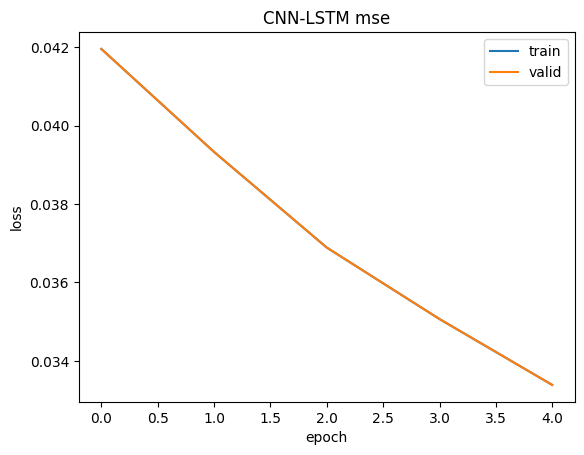

In [ ]:
# summarize history for loss
plt.plot(cnn_lstm_attention_history.history['mse'])
plt.plot(cnn_lstm_attention_history.history['mse'])
plt.title('CNN-LSTM mse')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'valid'], loc='upper right')
plt.show()

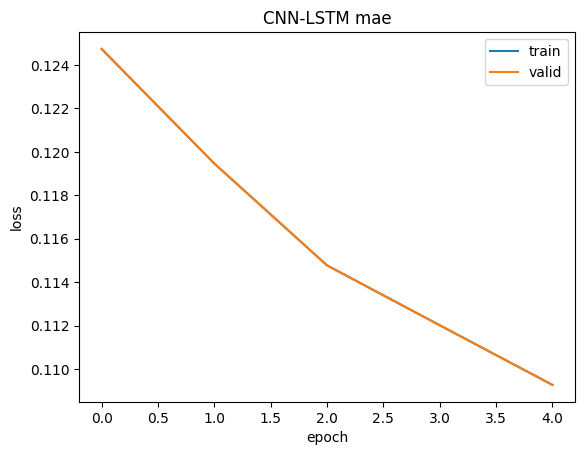

In [ ]:
# summarize history for loss
plt.plot(cnn_lstm_attention_history.history['mae'])
plt.plot(cnn_lstm_attention_history.history['mae'])
plt.title('CNN-LSTM mae')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'valid'], loc='upper right')
plt.show()

In [ ]:
cnn_lstm_train_pred = model_gru_bi_lstm.predict(train_Xcnn)
cnn_lstm_valid_pred = model_gru_bi_lstm.predict(valid_Xcnn)
cnn_lstm_test_pred = model_gru_bi_lstm.predict(test_Xcnn)
print('Error in Next 6-hour prediction of water level using CNN')
print('Train rmse:', np.sqrt(mean_squared_error(train_y[50:56],cnn_lstm_train_pred[50:56])))
print('Validation rmse:', np.sqrt(mean_squared_error(valid_y[50:56], cnn_lstm_valid_pred[50:56])))
print('Test rmse:', np.sqrt(mean_squared_error(test_y[50:56], cnn_lstm_test_pred[50:56])))
print('Test mae :', metrics.mean_absolute_error(test_y[50:56], cnn_lstm_test_pred[50:56]))
print('Test mse :', metrics.mean_squared_error(test_y[50:56], cnn_lstm_test_pred[50:56]))
print('**********************************************************************')
# def wape(actual, forecast):
#     return np.sum(np.abs(actual - forecast)) / np.sum(actual) * 100

# def nse(actual, forecast):
#     return 1 - np.sum((forecast - actual) ** 2) / np.sum((actual - np.mean(actual)) ** 2)
# wape_score = wape(test_y, cnn_lstm_test_pred)
# nse_score = nse(test_y, cnn_lstm_test_pred)

# print(f"Test WAPE: {wape_score:.2f}%")
# print(f"Test NSE: {nse_score:.4f}")

2291/2291 [==============================] - 14s 6ms/step
Error in Next 6-hour prediction of water level using CNN
Train rmse: 0.05133496567162303
Validation rmse: 0.2166400550626081
Test rmse: 0.014843105768138635
Test mae : 0.01277213255564369
Test mse : 0.0002203177888441504
**********************************************************************


2291/2291 [==============================] - 14s 6ms/step


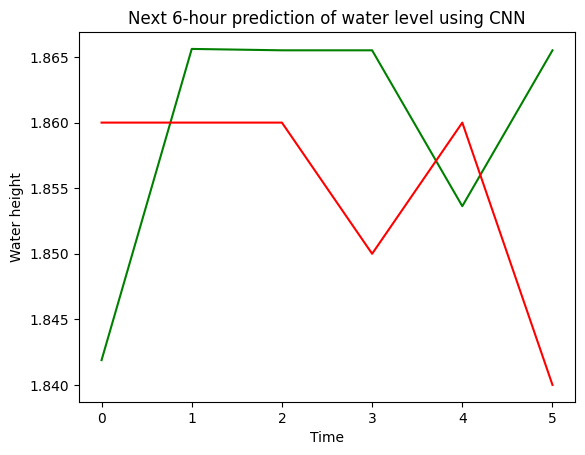

In [ ]:
# Plot the graph between actual vs predicted values
y_pred = model_gru_bi_lstm.predict(test_Xcnn)
plt.plot(y_pred[50:56], color='green')
plt.plot(test_y[50:56].flatten(), color='red')
plt.title("Next 6-hour prediction of water level using CNN")
plt.xlabel("Time")
plt.ylabel("Water height")
plt.show()

In [ ]:
from keras import backend as K
from sklearn.metrics import r2_score

y_pred = model_gru_bi_lstm.predict(test_Xcnn)

r2 = r2_score(cnn_lstm_test_pred[50:56], test_y[50:56])
print('r2 score for 6 Hour Prediction of this perfect model is', r2)

2291/2291 [==============================] - 14s 6ms/step
r2 score for 6 Hour Prediction of this perfect model is -1.6961652463391803


In [ ]:
cnn_lstm_train_pred = model_gru_bi_lstm.predict(train_Xcnn)
cnn_lstm_valid_pred = model_gru_bi_lstm.predict(valid_Xcnn)
cnn_lstm_test_pred = model_gru_bi_lstm.predict(test_Xcnn)
print('Error in Next 12-hour prediction of water level using CNN')
print('Train rmse:', np.sqrt(mean_squared_error(train_y[50:62],cnn_lstm_train_pred[50:62])))
print('Validation rmse:', np.sqrt(mean_squared_error(valid_y[50:62], cnn_lstm_valid_pred[50:62])))
print('Test rmse:', np.sqrt(mean_squared_error(test_y[50:62], cnn_lstm_test_pred[50:62])))
print('Test mae :', metrics.mean_absolute_error(test_y[50:62], cnn_lstm_test_pred[50:62]))
print('Test mse :', metrics.mean_squared_error(test_y[50:62], cnn_lstm_test_pred[50:62]))
print('**********************************************************************')
# def wape(actual, forecast):
#     return np.sum(np.abs(actual - forecast)) / np.sum(actual) * 100

# def nse(actual, forecast):
#     return 1 - np.sum((forecast - actual) ** 2) / np.sum((actual - np.mean(actual)) ** 2)
# wape_score = wape(test_y, cnn_lstm_test_pred)
# nse_score = nse(test_y, cnn_lstm_test_pred)

# print(f"Test WAPE: {wape_score:.2f}%")
# print(f"Test NSE: {nse_score:.4f}")

2291/2291 [==============================] - 14s 6ms/step
Error in Next 12-hour prediction of water level using CNN
Train rmse: 0.050361250450742266
Validation rmse: 0.2080126511761348
Test rmse: 0.01247742239889129
Test mae : 0.010594657262166315
Test mse : 0.00015568606972035407
**********************************************************************


2291/2291 [==============================] - 23s 10ms/step


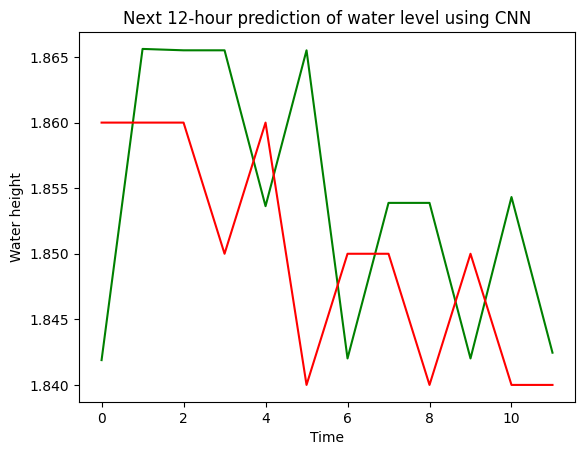

In [ ]:
# Plot the graph between actual vs predicted values
y_pred = model_gru_bi_lstm.predict(test_Xcnn)
plt.plot(y_pred[50:62], color='green')
plt.plot(test_y[50:62].flatten(), color='red')
plt.title("Next 12-hour prediction of water level using CNN")
plt.xlabel("Time")
plt.ylabel("Water height")
plt.show()

In [ ]:
from keras import backend as K
from sklearn.metrics import r2_score

y_pred = model_gru_bi_lstm.predict(test_Xcnn)

r2 = r2_score(cnn_lstm_test_pred[50:62], test_y[50:62])
print('r2 score for 12 Hour Prediction of this perfect model is', r2)

2291/2291 [==============================] - 15s 7ms/step
r2 score for 12 Hour Prediction of this perfect model is -0.6991554053433833


In [ ]:
cnn_lstm_train_pred = model_gru_bi_lstm.predict(train_Xcnn)
cnn_lstm_valid_pred = model_gru_bi_lstm.predict(valid_Xcnn)
cnn_lstm_test_pred = model_gru_bi_lstm.predict(test_Xcnn)
print('Error in Next 24-hour prediction of water level using CNN')
print('Train rmse:', np.sqrt(mean_squared_error(train_y[50:74],cnn_lstm_train_pred[50:74])))
print('Validation rmse:', np.sqrt(mean_squared_error(valid_y[50:74], cnn_lstm_valid_pred[50:74])))
print('Test rmse:', np.sqrt(mean_squared_error(test_y[50:74], cnn_lstm_test_pred[50:74])))
print('Test mae :', metrics.mean_absolute_error(test_y[50:74], cnn_lstm_test_pred[50:74]))
print('Test mse :', metrics.mean_squared_error(test_y[50:74], cnn_lstm_test_pred[50:74]))
print('**********************************************************************')


2291/2291 [==============================] - 14s 6ms/step
Error in Next 24-hour prediction of water level using CNN
Train rmse: 0.05305301227973176
Validation rmse: 0.19518337199402233
Test rmse: 0.010843004469732827
Test mae : 0.009040153423945077
Test mse : 0.00011757074593064607
**********************************************************************


2291/2291 [==============================] - 17s 8ms/step


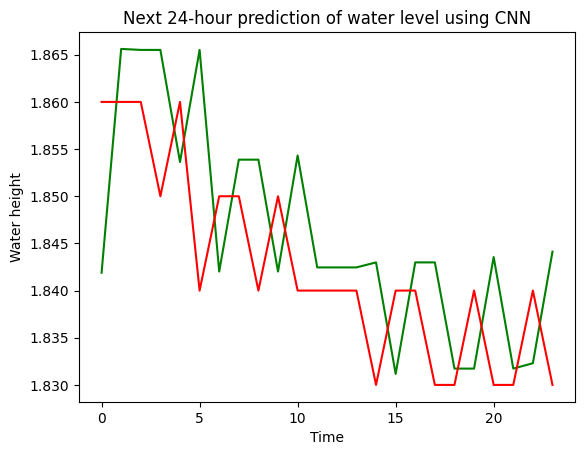

In [ ]:
# Plot the graph between actual vs predicted values
y_pred = model_gru_bi_lstm.predict(test_Xcnn)
plt.plot(y_pred[50:74], color='green')
plt.plot(test_y[50:74].flatten(), color='red')
plt.title("Next 24-hour prediction of water level using CNN")
plt.xlabel("Time")
plt.ylabel("Water height")
plt.show()

In [ ]:
from keras import backend as K
from sklearn.metrics import r2_score

y_pred = model_gru_bi_lstm.predict(test_Xcnn)

r2 = r2_score(cnn_lstm_test_pred[50:74], test_y[50:74])
print('r2 score for 24 Hour Prediction of this perfect model is', r2)

2291/2291 [==============================] - 16s 7ms/step
r2 score for 24 Hour Prediction of this perfect model is 0.033622771165793264


In [ ]:
cnn_lstm_train_pred = model_gru_bi_lstm.predict(train_Xcnn)
cnn_lstm_valid_pred = model_gru_bi_lstm.predict(valid_Xcnn)
cnn_lstm_test_pred = model_gru_bi_lstm.predict(test_Xcnn)
print('Error in Next 48-hour prediction of water level using CNN')
print('Train rmse:', np.sqrt(mean_squared_error(train_y[50:98],cnn_lstm_train_pred[50:98])))
print('Validation rmse:', np.sqrt(mean_squared_error(valid_y[50:98], cnn_lstm_valid_pred[50:98])))
print('Test rmse:', np.sqrt(mean_squared_error(test_y[50:98], cnn_lstm_test_pred[50:98])))
print('Test mae :', metrics.mean_absolute_error(test_y[50:98], cnn_lstm_test_pred[50:98]))
print('Test mse :', metrics.mean_squared_error(test_y[50:98], cnn_lstm_test_pred[50:98]))
print('**********************************************************************')


2291/2291 [==============================] - 14s 6ms/step
Error in Next 48-hour prediction of water level using CNN
Train rmse: 0.056080568922836575
Validation rmse: 0.16510467413556565
Test rmse: 0.011490698716059802
Test mae : 0.008499802450338961
Test mse : 0.00013203615698325838
**********************************************************************


2291/2291 [==============================] - 14s 6ms/step


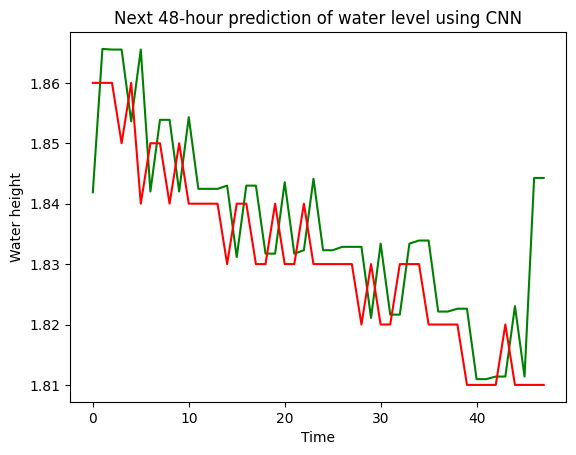

In [ ]:
# Plot the graph between actual vs predicted values
y_pred = model_gru_bi_lstm.predict(test_Xcnn)
plt.plot(y_pred[50:98], color='green')
plt.plot(test_y[50:98].flatten(), color='red')
plt.title("Next 48-hour prediction of water level using CNN")
plt.xlabel("Time")
plt.ylabel("Water height")
plt.show()

In [ ]:
from keras import backend as K
from sklearn.metrics import r2_score

y_pred = model_gru_bi_lstm.predict(test_Xcnn)

r2 = r2_score(cnn_lstm_test_pred[50:98], test_y[50:98])
print('r2 score for 48 Hour Prediction of this perfect model is', r2)

2291/2291 [==============================] - 14s 6ms/step
r2 score for 48 Hour Prediction of this perfect model is 0.37880160931467977
